In [ ]:
# 使用Colab可先run這裡的code
# 假如要連結自己的雲端硬碟再開啟
from google.colab import drive
# drive.mount('/content/gdrive')
# 檢查GPU
!nvidia-smi
# 安裝產生驗證碼的套件

Thu Aug 12 06:20:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install captcha

     |████████████████████████████████| 101 kB 5.6 MB/s 


In [ ]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random
import string
from keras import backend as K
from keras.models import *
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dense, Dropout, Reshape, Lambda

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


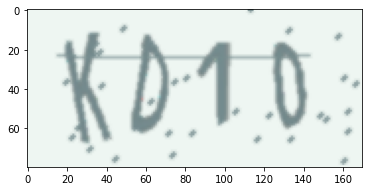

In [ ]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random
import string
from keras import backend as K
from keras.models import *
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dense, Dropout, Reshape, Lambda
# 驗證碼包含0-10數字以及26個英文字母
characters = string.digits + string.ascii_uppercase
print(characters)

# 設定產生圖片尺寸，以及總類別，n_class之所以要加一是為了留一個位置給Blank
width, height, n_len, n_class = 170, 80, 4, len(characters)+1

# 設定產生驗證碼的generator
generator = ImageCaptcha(width=width, height=height)

# 我們先練習固定長度4個字的驗證碼
random_str = ''.join([random.choice(characters) for i in range(4)])
img = generator.generate_image(random_str)

plt.imshow(img)
# plt.title(random_str)
# plt.show()

In [ ]:
# CTC Loss需要四個資訊，分別是
# Label
# 預測
# CNN OUTPUT寬度
# 預測影像所包含文字長度
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [ ]:
# height, width, channel = 170, 80, 3
input_tensor = Input((height, width, 3))
x = input_tensor

x = Conv2D(32, (3, 3), strides=(1, 1), padding="valid")(x)
x = BatchNormalization(axis=3)(x)
x = Conv2D(32, (3, 3), strides=(1, 1), padding="valid")(x)
x = BatchNormalization(axis=3)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(32, (3, 3), strides=(1, 1), padding="valid")(x)
x = BatchNormalization(axis=3)(x)
x = Conv2D(32, (3, 3), strides=(1, 1), padding="valid")(x)
x = BatchNormalization(axis=3)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(32, (3, 3), strides=(1, 1), padding="valid")(x)
x = BatchNormalization(axis=3)(x)
x = Conv2D(32, (3, 3), strides=(1, 1), padding="valid")(x)
x = BatchNormalization(axis=3)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(32, (3, 3), strides=(1, 1), padding="valid")(x)
x = BatchNormalization(axis=3)(x)
x = Conv2D(32, (3, 3), strides=(1, 1), padding="valid")(x)
x = BatchNormalization(axis=3)(x)
x = MaxPooling2D(pool_size=(2, 1))(x)

# 記錄輸出CNN尺寸，loss部分需要這個資訊
# conv_shape -> (Batch_size,輸出高度,輸出寬度,輸出深度)
conv_shape = x.get_shape()
# print(conv_shape) -> (None, 1, 13, 32)

# 從(Batch_size,輸出高度,輸出寬度,輸出深度)變成(Batch_size,輸出寬度,輸出高度*輸出深度)，以符合ctc loss需求
x = Reshape(target_shape=(int(conv_shape[2]), int(conv_shape[1]*conv_shape[3])))(x)
# x -> (None, 13, 32)
x = Dense(units=13, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(n_class, activation='softmax')(x)

# 包裝用來預測的model
base_model = Model(inputs=input_tensor, outputs=x)

# 設定要給CTC Loss的資訊
labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,),
                  name='ctc')([x, labels, input_length, label_length])

# 這裡的model是用來計算loss
model = Model(inputs=[input_tensor, labels, input_length, label_length], outputs=[loss_out])


# 之所以要lambda y_true, y_pred: y_pred是因為我們的loss已經包在網路裡，會output:y_true, y_pred，而我們只需要y_pred
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='SGD')
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 170, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 78, 168, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 78, 168, 32)  128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 76, 166, 32)  9248        batch_normalization[0][0]        
____________________________________________________________________________________________

Label:  [[26 16  0 18]]
CNN輸出寬度:  [13.]
字串長度(可浮動):  [4.]
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


200/200 [==============================] - 29s 147ms/step - loss: 15.1222
Epoch 2/20
200/200 [==============================] - 28s 139ms/step - loss: 14.3678
Epoch 3/20
200/200 [==============================] - 29s 146ms/step - loss: 13.5090
Epoch 4/20
200/200 [==============================] - 28s 142ms/step - loss: 12.5876
Epoch 5/20
200/200 [==============================] - 29s 145ms/step - loss: 11.5379
Epoch 6/20
200/200 [==============================] - 30s 149ms/step - loss: 10.5581
Epoch 7/20
200/200 [==============================] - 29s 144ms/step - loss: 9.9070
Epoch 8/20
200/200 [==============================] - 28s 139ms/step - loss: 9.3654
Epoch 9/20
200/200 [==============================] - 30s 148ms/step - loss: 8.8329
Epoch 10/20
200/200 [==============================] - 28s 139ms/step - loss: 8.5042
Epoch 11/20
200/200 [==============================] - 29s 146ms/step - loss: 8.1092
Epoch 12/20
200/200 [==============================] - 28s 140ms/step - loss: 7

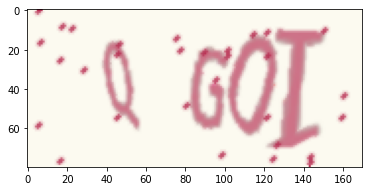

In [ ]:
# 設計generator產生training data
# 產生包含要給loss的資訊
# X=輸入影像
# np.ones(batch_size)*int(conv_shape[2])=CNN輸出feature Map寬度
# np.ones(batch_size)*n_len=字串長度(可浮動)
def gen(batch_size=128):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = np.zeros((batch_size, n_len), dtype=np.uint8)
    while True:
        generator = ImageCaptcha(width=width, height=height)
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = np.array(generator.generate_image(random_str))
            y[i] = [characters.find(x) for x in random_str]
        yield [X, y, np.ones(batch_size)*int(conv_shape[2]), np.ones(batch_size)*n_len], np.ones(batch_size)


next_ge = gen(batch_size=1)
test_ge = next(next_ge)
plt.imshow(test_ge[0][0][0])
# plt.show()
print('Label: ', test_ge[0][1])
print('CNN輸出寬度: ', test_ge[0][2])
print('字串長度(可浮動): ', test_ge[0][3])


model.fit_generator(gen(32), steps_per_epoch=200, epochs=20)

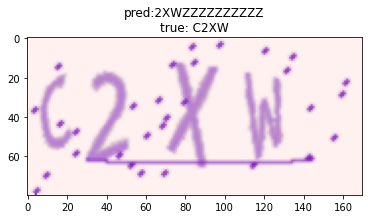

In [ ]:
characters2 = characters + ' '
[X_test, y_test, _, _], _  = next(gen(1))
y_pred = base_model.predict(X_test)
##用ctc_decode得到解答，自己寫可以參考下方
out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])
out = ''.join([characters[x] for x in out[0]])
y_true = ''.join([characters[x] for x in y_test[0]])

plt.imshow(X_test[0])
plt.title('pred:' + str(out) + '\ntrue: ' + str(y_true))

argmax = np.argmax(y_pred, axis=2)[0]